In [88]:
import tensorflow as tf
import numpy as np
from keras.applications.efficientnet import EfficientNetB0, preprocess_input
from keras.layers import Dense, GlobalAveragePooling2D, Input
from keras.models import Model

from keras.preprocessing.image import ImageDataGenerator

from keras.losses import SparseCategoricalCrossentropy, CategoricalCrossentropy
from keras.optimizers import Adam

from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc
from tabulate import tabulate
# from keras.callbacks import ModelCheckpoint

In [89]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)

1 Physical GPUs, 1 Logical GPUs


In [93]:
# Xây dựng mô hình
num_classes = 4
IMG_SIZE = 224

inputs = tf.keras.layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3))

base_model = tf.keras.applications.efficientnet.EfficientNetB0(weights=None, include_top=True, classes=num_classes, drop_connect_rate=0.25)  # Sử dụng trọng số được đào tạo trước

predictions = base_model(inputs)
# x = base_model(base_model.input, training=True)
# x = tf.keras.layers.GlobalAveragePooling2D()(x)
# x = tf.keras.layers.Dense(1024, activation='relu')(x)
# x = tf.keras.layers.Dropout(0.25)(x)
# x = tf.keras.layers.Dense(1024, activation='relu')(x)
# x = tf.keras.layers.Dropout(0.25)(x)
# x = tf.keras.layers.Dense(512, activation='relu')(x)
# predictions = tf.keras.layers.Dense(num_classes, activation='softmax')(x)

model = Model(inputs=inputs, outputs=predictions)

# Đóng băng các lớp của mô hình base
for layer in base_model.layers:
    layer.trainable = True

model.summary()

Model: "model_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_24 (InputLayer)       [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetb0 (Functional  (None, 4)                 4054695   
 )                                                               
                                                                 
Total params: 4054695 (15.47 MB)
Trainable params: 4012672 (15.31 MB)
Non-trainable params: 42023 (164.16 KB)
_________________________________________________________________


In [94]:
# Định nghĩa các tham số cho việc đọc và tiền xử lý dữ liệu ảnh
data_dir = 'data_final'
batch_size = 32
epochs = 40
image_size = (224, 224)  # Kích thước ảnh đầu vào của EfficientNetB0


# Sử dụng ImageDataGenerator để đọc và tiền xử lý dữ liệu ảnh
datagen = ImageDataGenerator(
    rescale=1./255,  # Chuẩn hóa giá trị pixel về khoảng [0, 1]
    validation_split=0.2,  # Phân chia dữ liệu thành tập huấn luyện và tập kiểm tra
    rotation_range=20,  # Xoay ảnh
    width_shift_range=0.2,  # Dịch ngang
    height_shift_range=0.2,  # Dịch dọc
    horizontal_flip=True,  # Lật ảnh ngang
    vertical_flip=False,  # Không lật ảnh dọc
    fill_mode='nearest'  # Điền giá trị khi biên ảnh bị cắt
)

# Đọc dữ liệu ảnh từ thư mục và áp dụng tiền xử lý
train_data_generator = datagen.flow_from_directory(
    data_dir,
    target_size=image_size,
    batch_size=batch_size,
    subset='training',  # Chỉ sử dụng tập huấn luyện
    class_mode = 'categorical'
)

val_data_generator = datagen.flow_from_directory(
    data_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode = 'categorical',
    subset='validation'  # Chỉ sử dụng tập kiểm tra
)

train_labels = train_data_generator.classes
val_labels = val_data_generator.classes


Found 14555 images belonging to 4 classes.
Found 3637 images belonging to 4 classes.


In [95]:
checkpoint_filepath = 'checkpoint/' 

model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_loss',
    mode='max',
    save_best_only=True)

In [96]:
loss = CategoricalCrossentropy()
optimizer = Adam(learning_rate=0.0001)

In [97]:
model.compile(loss=loss, optimizer=optimizer, metrics=['accuracy'])

In [98]:
step_train = train_data_generator.n // batch_size
step_val = val_data_generator.n // batch_size
history = model.fit(train_data_generator,
          steps_per_epoch=step_train,
          validation_steps= step_val, 
          batch_size=batch_size, 
          epochs=epochs, 
          validation_data=val_data_generator, 
          callbacks=[model_checkpoint_callback])


Epoch 1/40


2023-09-16 13:22:47.455091: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_16/efficientnetb0/block2b_drop/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


454/454 [==============================] - 322s 612ms/step - loss: 1.5812 - accuracy: 0.5245 - val_loss: 3.8917 - val_accuracy: 0.3413
Epoch 2/40
454/454 [==============================] - 270s 595ms/step - loss: 1.1459 - accuracy: 0.6694 - val_loss: 0.7053 - val_accuracy: 0.7636
Epoch 3/40
454/454 [==============================] - 276s 607ms/step - loss: 0.8895 - accuracy: 0.7189 - val_loss: 2.5388 - val_accuracy: 0.7483
Epoch 4/40
454/454 [==============================] - 270s 594ms/step - loss: 0.8110 - accuracy: 0.7534 - val_loss: 1.7446 - val_accuracy: 0.7663
Epoch 5/40
454/454 [==============================] - 270s 594ms/step - loss: 0.7139 - accuracy: 0.7706 - val_loss: 0.5333 - val_accuracy: 0.8095
Epoch 6/40
454/454 [==============================] - 268s 589ms/step - loss: 0.6909 - accuracy: 0.7845 - val_loss: 0.5685 - val_accuracy: 0.8213
Epoch 7/40
454/454 [==============================] - 266s 584ms/step - loss: 0.6583 - accuracy: 0.7917 - val_loss: 0.6128 - val_accura

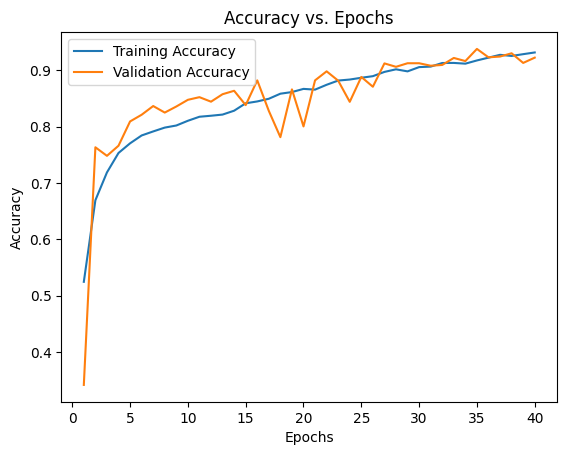

In [100]:
# Lấy thông tin về độ chính xác trên tập huấn luyện và tập validation
train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

# Vẽ đồ thị biểu diễn sự thay đổi của accuracy
plt.plot(range(1, epochs + 1), train_accuracy, label='Training Accuracy')
plt.plot(range(1, epochs + 1), val_accuracy, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy vs. Epochs')
plt.legend()
plt.show()

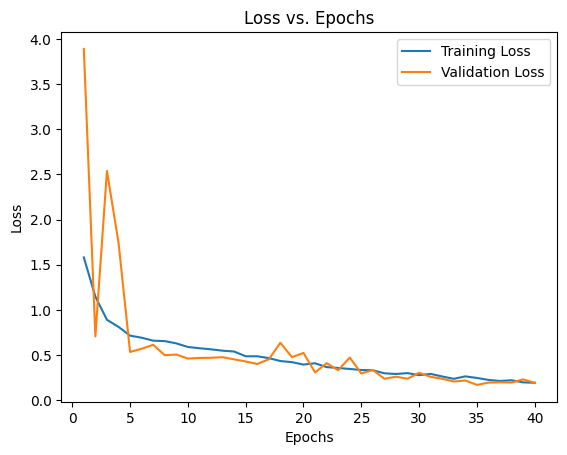

In [101]:
# Lấy thông tin về loss trên tập huấn luyện và tập validation
train_loss = history.history['loss']
val_loss = history.history['val_loss']

# Vẽ đồ thị biểu diễn sự thay đổi của loss
plt.plot(range(1, epochs + 1), train_loss, label='Training Loss')
plt.plot(range(1, epochs + 1), val_loss, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss vs. Epochs')
plt.legend()
plt.show()


In [102]:
# Đánh giá mô hình trên tập kiểm tra
val_loss, val_accuracy = model.evaluate(val_data_generator)
print(f'Val loss: {val_loss}, Val accuracy: {val_accuracy}')

# Lưu mô hình
model.save('efficientnet_b0_model.h5')

114/114 [==============================] - 54s 473ms/step - loss: 0.1918 - accuracy: 0.9227
Val loss: 0.19182606041431427, Val accuracy: 0.9227384924888611


/home/ducna/anaconda3/envs/keras/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


### Confusion Matrix

In [103]:
# Lấy danh sách các lớp từ tên thư mục trong val_data_generator
class_names = list(val_data_generator.class_indices.keys())

# Lấy chỉ số thứ tự của các lớp trong tập kiểm tra
y_true_indices = val_data_generator.classes

# Sử dụng chỉ số thứ tự để lấy tên của các lớp từ danh sách tên lớp
y_true_classes = [class_names[i] for i in y_true_indices]

# Dự đoán trên tập kiểm tra
model.load_weights(checkpoint_filepath)
y_pred = model.predict(val_data_generator)
y_pred = [np.argmax(y) for y in y_pred]  # Chuyển đổi từ dạng one-hot về số nguyên

# Tạo confusion matrix với tên của các lớp
cm = confusion_matrix(y_true_classes, [class_names[i] for i in y_pred])

# Hiển thị confusion matrix bằng heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('Real')
plt.show()


2023-09-16 16:26:04.702299: W tensorflow/core/util/tensor_slice_reader.cc:97] Could not open checkpoint/: FAILED_PRECONDITION: checkpoint; Is a directory: perhaps your file is in a different file format and you need to use a different restore operator?


IsADirectoryError: [Errno 21] Unable to open file (file read failed: time = Sat Sep 16 16:26:05 2023
, filename = 'checkpoint/', file descriptor = 88, errno = 21, error message = 'Is a directory', buf = 0x7ffc18aa79d8, total read size = 8, bytes this sub-read = 8, bytes actually read = 18446744073709551615, offset = 0)

114/114 [==============================] - 45s 396ms/step


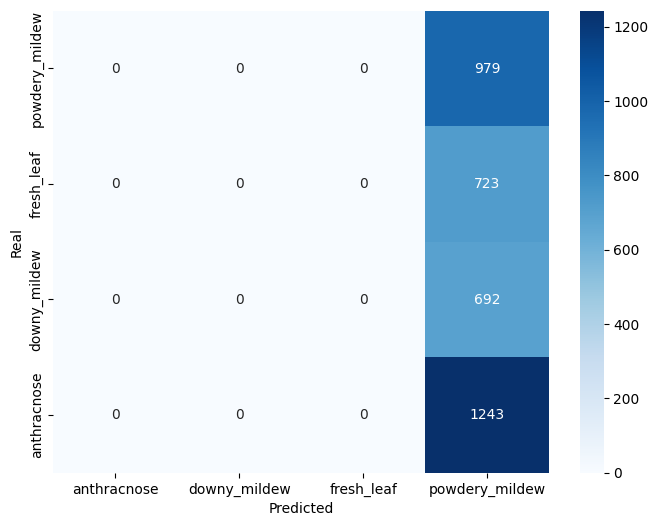

In [ ]:
# Lấy danh sách các lớp từ tên thư mục trong val_data_generator
class_names = list(val_data_generator.class_indices.keys())

# Lấy chỉ số thứ tự của các lớp trong tập kiểm tra
y_true_indices = val_data_generator.classes

# Sử dụng chỉ số thứ tự để lấy tên của các lớp từ danh sách tên lớp
y_true_classes = [class_names[i] for i in y_true_indices]

# Dự đoán trên tập kiểm tra
model.load_weights(checkpoint_filepath)
y_pred = model.predict(val_data_generator)
y_pred = [np.argmax(y) for y in y_pred]  # Chuyển đổi từ dạng one-hot về số nguyên

# Tạo ma trận nhầm lẫn
cm = confusion_matrix(y_true_classes, [class_names[i] for i in y_pred])

# Đảo ngược thứ tự của danh sách tên lớp và ma trận nhầm lẫn


# Hiển thị confusion matrix bằng heatmap với trục y đã được đảo ngược
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names[::-1])
plt.xlabel('Predicted')
plt.ylabel('Real')
plt.show()


In [ ]:
# Chuyển đổi danh sách tên lớp thành danh sách chỉ số tương ứng
class_indices = {class_name: i for i, class_name in enumerate(class_names)}
y_true_indices = [class_indices[class_name] for class_name in y_true_classes]

# Dự đoán trên tập kiểm tra
model.load_weights(checkpoint_filepath)
y_pred = model.predict(val_data_generator)
y_pred_indices = [np.argmax(y) for y in y_pred]  # Chuyển đổi từ dạng one-hot về số nguyên

# Tính và in classification report
report = classification_report(y_true_indices, y_pred_indices, target_names=class_names, output_dict=True)
report_table = []
for class_name, metrics in report.items():
    if class_name in class_names:
        row = [class_name, metrics['precision'], metrics['recall'], metrics['f1-score'], metrics['support']]
        report_table.append(row)

headers = ["Class", "Precision", "Recall", "F1-Score", "Support"]
print(tabulate(report_table, headers, tablefmt="pretty"))


114/114 [==============================] - 45s 392ms/step
+----------------+---------------------+--------+--------------------+---------+
|     Class      |      Precision      | Recall |      F1-Score      | Support |
+----------------+---------------------+--------+--------------------+---------+
|  anthracnose   |         0.0         |  0.0   |        0.0         |  979.0  |
|  downy_mildew  |         0.0         |  0.0   |        0.0         |  723.0  |
|   fresh_leaf   |         0.0         |  0.0   |        0.0         |  692.0  |
| powdery_mildew | 0.34176519109155895 |  1.0   | 0.5094262295081967 | 1243.0  |
+----------------+---------------------+--------+--------------------+---------+


/home/ducna/anaconda3/envs/keras/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ducna/anaconda3/envs/keras/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ducna/anaconda3/envs/keras/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
